# Predicting Procurement Compliance Using KPI-Driven Machine Learning Models

**Author:** Brittany Dowdle

**Date:** 7/13/2025

**Objective:** This notebook is part of the overall [capstone project](https://github.com/Bdowdle4/Dowdle_Analytics_Capstone). The ultimate goal is to identify patterns and predictors of non-compliant suppliers using machine learning techniques.

## Introduction
This project uses the [Procurement KPI Analysis Dataset](https://www.kaggle.com/datasets/shahriarkabir/procurement-kpi-analysis-dataset) to predict compliance of suppliers. The dataset includes purchase order records from 5 different suppliers from 2022-2023. This notebook will be used to discover patterns, spot anomalies, test a hypothesis, and check assumptions to ensure the model will produce valid results.  

****

### Imports
In the code cell below are the necessary Python libraries for this notebook. *All imports should be at the top of the notebook.*

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

****
### 1. Load the Cleaned Dataset

In [3]:
# Load the dataset
df = pd.read_csv("C:/Users/Britt/Documents/44688/Dowdle_Analytics_Capstone/Data/cleaned_procurement_data.csv")

# Show the structure of the dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 758 entries, 0 to 757
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   po_id                       758 non-null    object 
 1   supplier                    758 non-null    object 
 2   order_date                  758 non-null    object 
 3   delivery_date               758 non-null    object 
 4   item_category               758 non-null    object 
 5   order_status                758 non-null    object 
 6   quantity                    758 non-null    int64  
 7   unit_price                  758 non-null    float64
 8   negotiated_price            758 non-null    float64
 9   defective_units             758 non-null    float64
 10  compliance                  758 non-null    object 
 11  lead_time_days              758 non-null    float64
 12  delivery_date_missing_flag  758 non-null    int64  
 13  price_diff                  758 non

### 2. Trend Line Charts

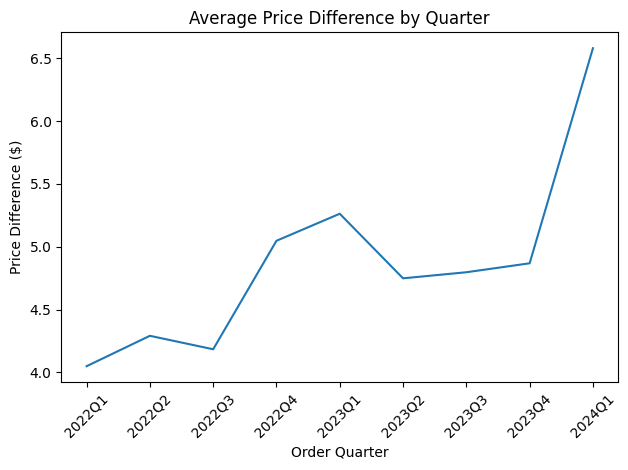

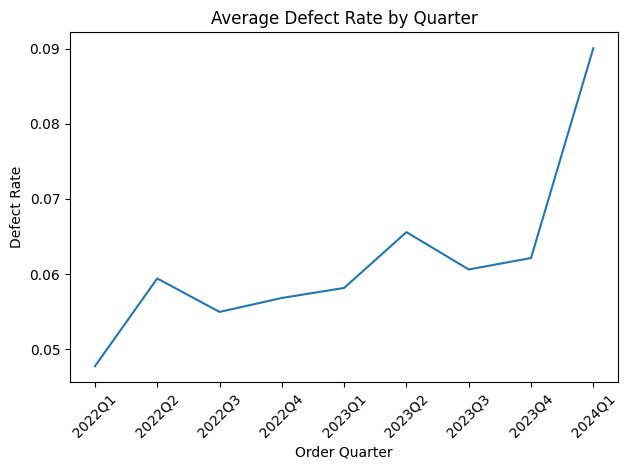

In [15]:
# Create quarterly defect rate
df['order_quarter'] = df['order_date'].dt.to_period('Q')

# Quarterly average price_diff
price_diff_trend = df.groupby('order_quarter')['price_diff'].mean().reset_index()
price_diff_trend['order_quarter'] = price_diff_trend['order_quarter'].astype(str)

sns.lineplot(data=price_diff_trend, x='order_quarter', y='price_diff')
plt.title("Average Price Difference by Quarter")
plt.xlabel("Order Quarter")
plt.ylabel("Price Difference ($)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Quarterly defect rate
defect_trend = df.groupby('order_quarter')['defect_rate'].mean().reset_index()
defect_trend['order_quarter'] = defect_trend['order_quarter'].astype(str)

sns.lineplot(data=defect_trend, x='order_quarter', y='defect_rate')
plt.title("Average Defect Rate by Quarter")
plt.xlabel("Order Quarter")
plt.ylabel("Defect Rate")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 3. Numerical Column Distributions

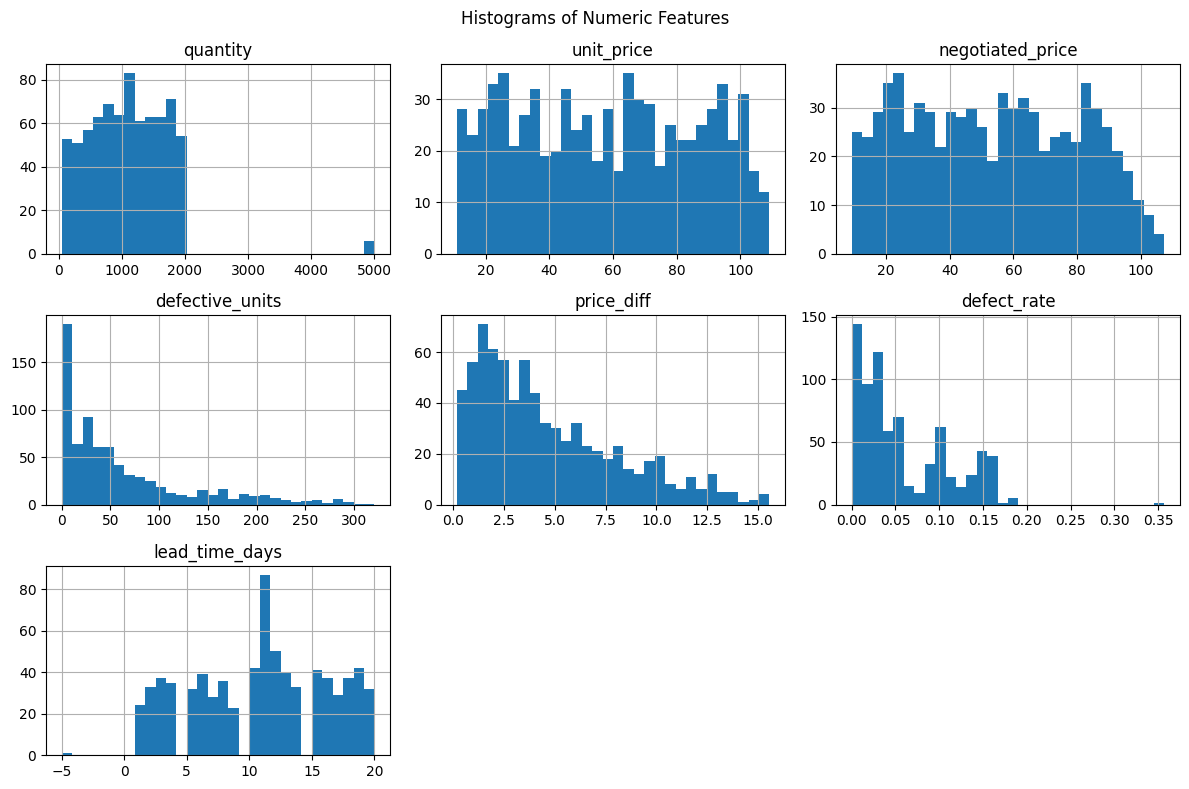

In [4]:
numeric_cols = ['quantity', 'unit_price', 'negotiated_price', 'defective_units', 'price_diff', 'defect_rate', 'lead_time_days']

# Histograms
df[numeric_cols].hist(bins=30, figsize=(12, 8))
plt.suptitle("Histograms of Numeric Features")
plt.tight_layout()
plt.show()

### 4. Categorical Column Distributions

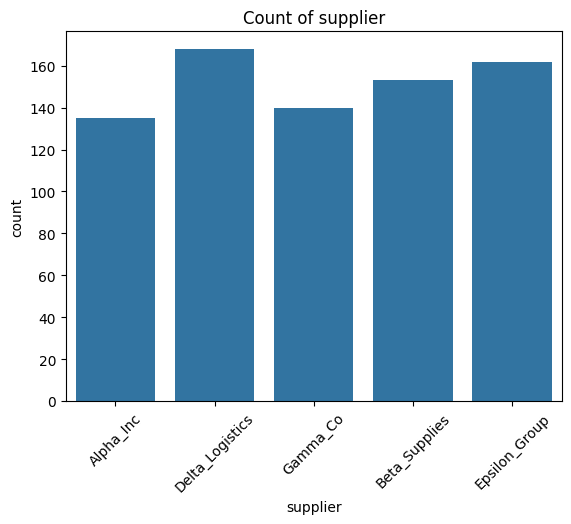

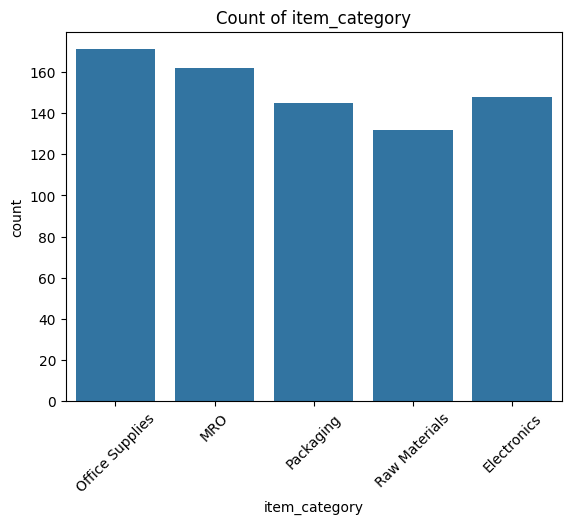

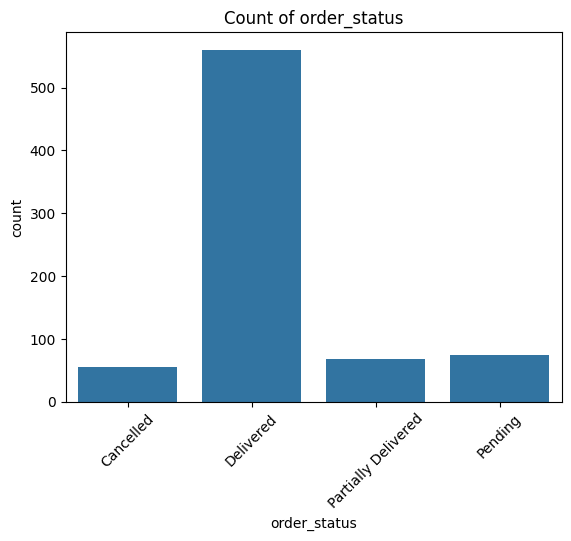

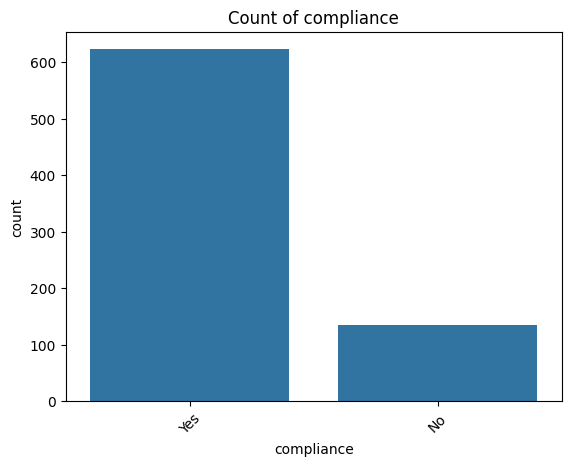

In [5]:
categorical_cols = ['supplier', 'item_category', 'order_status', 'compliance']

for col in categorical_cols:
    sns.countplot(x=df[col])
    plt.title(f"Count of {col}")
    plt.xticks(rotation=45)
    plt.show()

### 5. Correlation Matrix

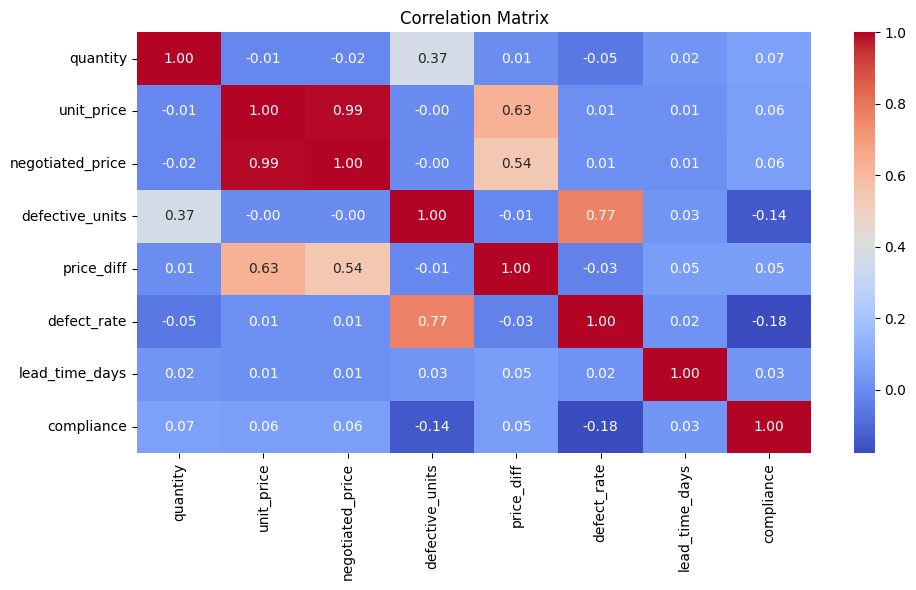

In [7]:
# Convert values to integers
df['compliance'] = df['compliance'].map({'Yes': 1, 'No': 0})

# Correlation of numerical features
correlation = df[numeric_cols + ['compliance']].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

### 6. Vendor Comparisons

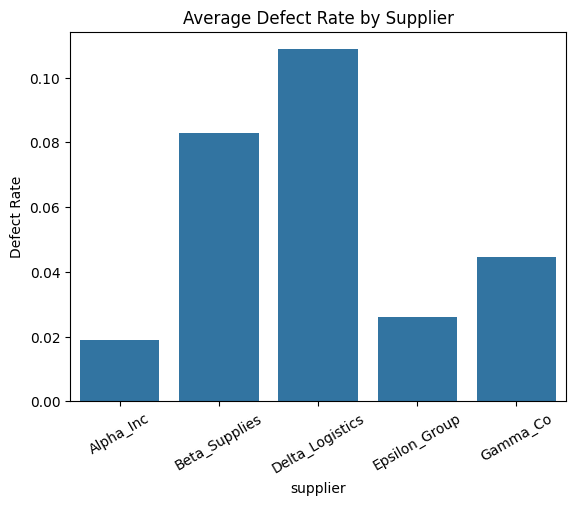

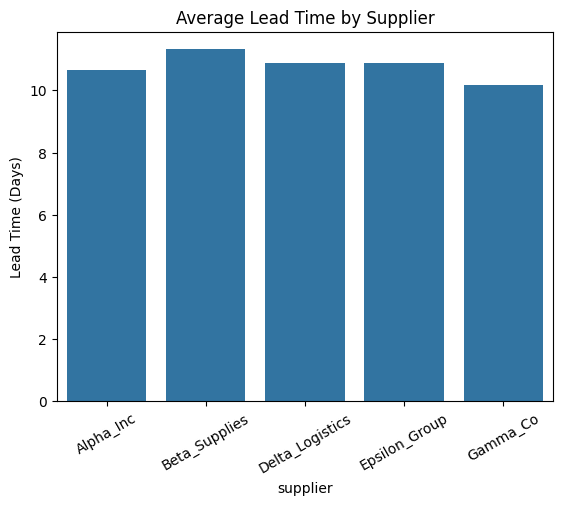

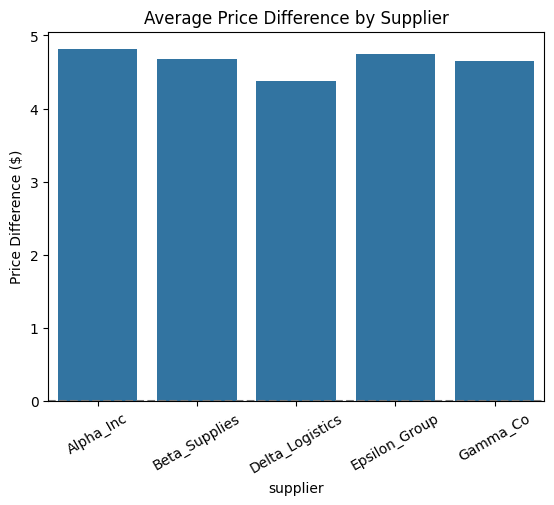

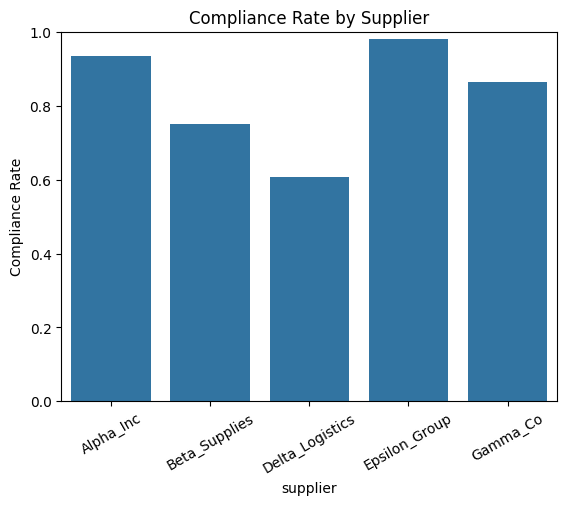

In [13]:
# Compare average defect rate, lead time, and price_diff by supplier
supplier_perf = df.groupby('supplier')[['defect_rate', 'lead_time_days', 'price_diff']].mean().reset_index()

# Bar plot: Average Defect Rate
sns.barplot(data=supplier_perf, x='supplier', y='defect_rate')
plt.title("Average Defect Rate by Supplier")
plt.ylabel("Defect Rate")
plt.xticks(rotation=30)
plt.show()

# Bar plot: Average Lead Time
sns.barplot(data=supplier_perf, x='supplier', y='lead_time_days')
plt.title("Average Lead Time by Supplier")
plt.ylabel("Lead Time (Days)")
plt.xticks(rotation=30)
plt.show()

# Bar plot: Average Price Difference
sns.barplot(data=supplier_perf, x='supplier', y='price_diff')
plt.title("Average Price Difference by Supplier")
plt.ylabel("Price Difference ($)")
plt.axhline(0, color='gray', linestyle='--')  # Optional: baseline
plt.xticks(rotation=30)
plt.show()

# Bar plot: Compliance Rate by Supplier
compliance_rate = df.groupby('supplier')['compliance'].mean().reset_index()
sns.barplot(data=compliance_rate, x='supplier', y='compliance')
plt.title("Compliance Rate by Supplier")
plt.ylim(0, 1)
plt.ylabel("Compliance Rate")
plt.xticks(rotation=30)
plt.show()
